In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

# Homie
Numerous apartment rental websites in London meticulously outline the details of available apartments in any given city. However, these platforms often lack comprehensive information about essential services and amenities surrounding the apartments. This raises a pertinent question: what is the ideal solution for individuals seeking accommodation near a Hospital, requiring 2 Bathrooms, and with a monthly rent budget of under 1500 pounds?

Introducing "HOMIE" – our innovative scalable solution designed to alleviate the hassle of extensive research. With HOMIE, we offer the answer to your query, saving you valuable time that would otherwise be spent on exhaustive searches.


## EDA

In [3]:
# Load your CSV file into a Pandas DataFrame
df = pd.read_csv('../../data/raw/housinganywhere_data.csv')

# Display the first few rows of the dataframe
df.head()

,Unnamed: 0,address,price_per_month,price_per_week,let_available_date,deposit,min_tenancy,furnish_type,let_type,house_type,bedrooms,bathrooms,dimensions,description
0,https://housinganywhere.com/room/ut1460416/gb/...,"Leman Street, London",GBP 1660,0,now,5 months,1 month,Furnished,Long term,Entire apartment,Studio,2,Property: 16 m²,Drapery Place is located right in the heart of...
1,https://housinganywhere.com/room/ut1483563/gb/...,"James Avenue, London",GBP 1158,0,now,GBP 1158,3 months,Furnished,Long term,Entire apartment,Studio,1,Property: 17 m²,Presenting Our Desirable Unit with a Private P...
2,https://housinganywhere.com/room/ut1355769/gb/...,"Olympic Way, London",GBP 1750,0,now,GBP 2187,6 months,Furnished,Long term,Entire apartment,Studio,2,Property: 41 m²,"Modern living, reinvented. Experience our all-..."
3,https://housinganywhere.com/room/ut1482540/gb/...,"Anson Road, London",GBP 897,0,now,GBP 897,3 months,Furnished,Long term,Entire apartment,Studio,2,Property: 18 m²,💢💢💢\n\n🔸Please note that advertised sizes are ...
4,https://housinganywhere.com/room/ut1483903/gb/...,"Blenheim Gardens, London",GBP 1200,0,now,GBP 1167,3 months,Furnished,Long term,Entire apartment,Studio,2,Property: 17 m²,💢💢💢\n\n🔸Please note that advertised sizes are ...


In [9]:
# Summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          696 non-null    object
 1   address             696 non-null    object
 2   price_per_month     696 non-null    object
 3   price_per_week      696 non-null    int64 
 4   let_available_date  696 non-null    object
 5   deposit             696 non-null    object
 6   min_tenancy         696 non-null    object
 7   furnish_type        696 non-null    object
 8   let_type            696 non-null    object
 9   house_type          696 non-null    object
 10  bedrooms            696 non-null    object
 11  bathrooms           696 non-null    int64 
 12  dimensions          696 non-null    object
 13  description         696 non-null    object
dtypes: int64(2), object(12)
memory usage: 76.3+ KB


In [10]:
# Summary statistics of numerical columns
df.describe()

,price_per_week,bathrooms
count,696.0,696.000000
mean,0.0,1.737069
std,0.0,0.443796
min,0.0,0.000000
25%,0.0,1.000000
50%,0.0,2.000000
75%,0.0,2.000000
max,0.0,2.000000


In [11]:
# Check for missing values
df.isnull().sum()

Unnamed: 0            0
address               0
price_per_month       0
price_per_week        0
let_available_date    0
deposit               0
min_tenancy           0
furnish_type          0
let_type              0
house_type            0
bedrooms              0
bathrooms             0
dimensions            0
description           0
dtype: int64

## Cleaning the data

In [16]:
# Extract the price from the string and make it an int
df['price_per_month'] = df['price_per_month'].str.replace('GBP ', '')
df['price_per_month'] = df['price_per_month'].str.replace('€', '')
df['price_per_month'] = df['price_per_month'].astype(str)
df['price_per_month'] = df['price_per_month'].apply(lambda x: sum(map(int, x.split('-'))) / 2 if '-' in x else int(x))
df['price_per_month'] = df['price_per_month'].astype(int)

# Calculate price per week
df['price_per_week'] = (df['price_per_month'] / 4).round().astype(int)

# Convert Deposit
df['deposit'] = df['deposit'].str.replace('GBP ', '')
# Replace 'Rent' with the corresponding value from 'price_per_month' column
df['deposit'] = df.apply(lambda row: str(row['price_per_month']) if row['deposit'] == 'Rent' else row['deposit'], axis=1)
def extract_and_multiply(string, price):
    match = re.search(r'\d+', string)
    if match:
        numeric_value = int(match.group())
        return numeric_value * price
    else:
        return None

# Apply the function to the 'deposit' and 'price_per_month' columns
df['deposit'] = df.apply(lambda row: extract_and_multiply(row['deposit'], row['price_per_month']) if 'months' in row['deposit'] else row['deposit'], axis=1)

# Replace 'Entire apartment' with 'Apartment' and 'Entire house' with 'House' in the 'house_type' column
df['house_type'] = df['house_type'].replace({'Entire apartment': 'Apartment', 'Entire house': 'House'})

# Define a function to extract the number from dimensions
def extract_numeric(string):
    match = re.search(r'\d+', string)  # Find the first occurrence of one or more digits
    if match:
        return int(match.group())  # Extract and return the numeric value as an integer
    else:
        return None  # Return None if no numeric value is found

# Apply the function to the 'property_description' column
df['dimensions_sq_m'] = df['dimensions'].apply(lambda x: extract_numeric(x))
df.drop("dimensions", axis='columns', inplace=True)

# Define a function to extract the numeric value or set it to 1 if 'Studio'
def extract_bedrooms(string):
    match = re.search(r'\d+', string)  # Find the first occurrence of one or more digits
    if match:
        return int(match.group())  # Extract and return the numeric value as an integer
    elif 'Studio' in string:
        return 1  # Set it to 1 if 'Studio'
    else:
        return None  # Return None if no numeric value is found

# Apply the function to the 'bedrooms' column
df['bedrooms'] = df['bedrooms'].apply(lambda x: extract_bedrooms(x))

In [17]:
df.head()

,Unnamed: 0,address,price_per_month,price_per_week,let_available_date,deposit,min_tenancy,furnish_type,let_type,house_type,bedrooms,bathrooms,description,dimensions_sq_m
0,https://housinganywhere.com/room/ut1460416/gb/...,"Leman Street, London",1660,415,now,8300,1 month,Furnished,Long term,Apartment,1,2,Drapery Place is located right in the heart of...,16.0
1,https://housinganywhere.com/room/ut1483563/gb/...,"James Avenue, London",1158,290,now,1158,3 months,Furnished,Long term,Apartment,1,1,Presenting Our Desirable Unit with a Private P...,17.0
2,https://housinganywhere.com/room/ut1355769/gb/...,"Olympic Way, London",1750,438,now,2187,6 months,Furnished,Long term,Apartment,1,2,"Modern living, reinvented. Experience our all-...",41.0
3,https://housinganywhere.com/room/ut1482540/gb/...,"Anson Road, London",897,224,now,897,3 months,Furnished,Long term,Apartment,1,2,💢💢💢\n\n🔸Please note that advertised sizes are ...,18.0
4,https://housinganywhere.com/room/ut1483903/gb/...,"Blenheim Gardens, London",1200,300,now,1167,3 months,Furnished,Long term,Apartment,1,2,💢💢💢\n\n🔸Please note that advertised sizes are ...,17.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          696 non-null    object 
 1   address             696 non-null    object 
 2   price_per_month     696 non-null    int64  
 3   price_per_week      696 non-null    int64  
 4   let_available_date  696 non-null    object 
 5   deposit             696 non-null    object 
 6   min_tenancy         696 non-null    object 
 7   furnish_type        696 non-null    object 
 8   let_type            696 non-null    object 
 9   house_type          696 non-null    object 
 10  bedrooms            696 non-null    int64  
 11  bathrooms           696 non-null    int64  
 12  description         696 non-null    object 
 13  dimensions_sq_m     691 non-null    float64
dtypes: float64(1), int64(4), object(9)
memory usage: 76.3+ KB


In [19]:
df.describe()

,price_per_month,price_per_week,bedrooms,bathrooms,dimensions_sq_m
count,696.000000,696.000000,696.000000,696.000000,691.000000
mean,4458.586207,1114.669540,1.597701,1.737069,67.953690
std,1882.931268,470.733507,0.719068,0.443796,88.709659
min,897.000000,224.000000,1.000000,0.000000,1.000000
25%,3178.250000,794.750000,1.000000,1.000000,42.000000
50%,4236.000000,1059.000000,1.000000,2.000000,55.000000
75%,5506.500000,1376.750000,2.000000,2.000000,74.500000
max,9810.000000,2452.000000,5.000000,2.000000,1000.000000


## Plot the data

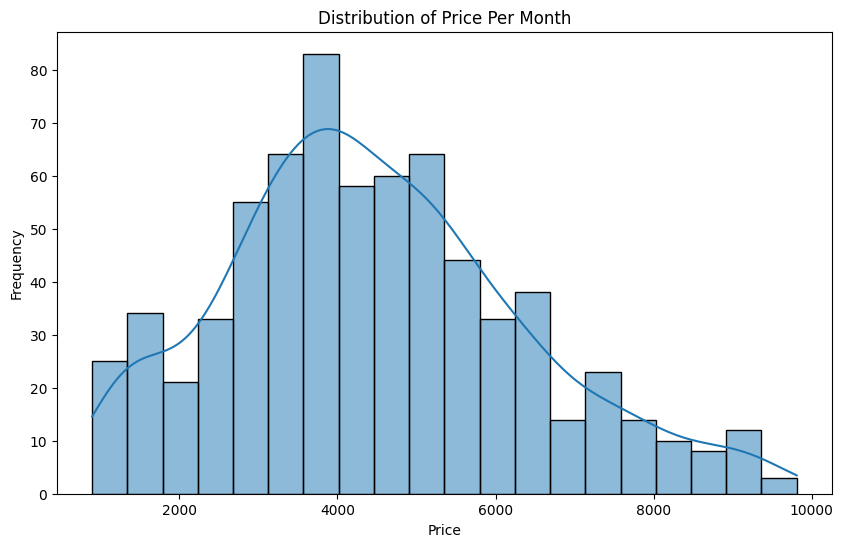

In [20]:
# Plot the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_month'], bins=20, kde=True)
plt.title('Distribution of Price Per Month')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

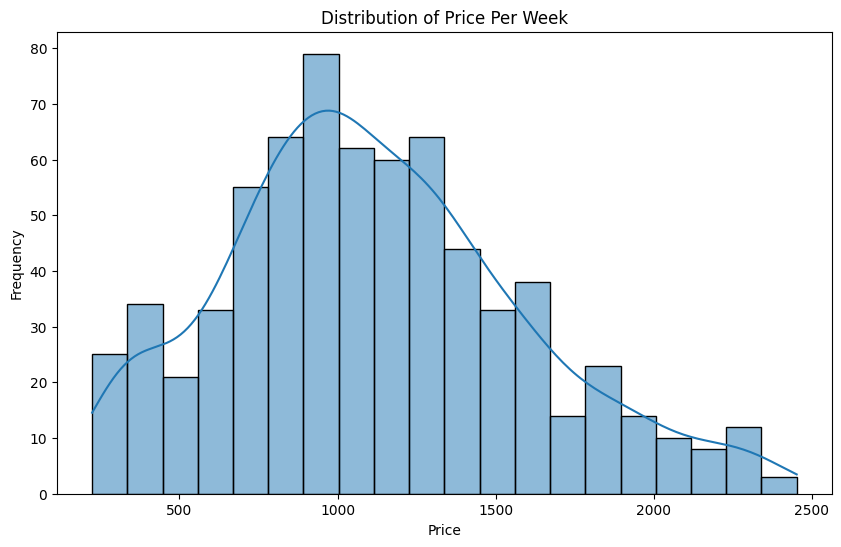

In [21]:
# Plot the distribution of prices per week
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_week'], bins=20, kde=True)
plt.title('Distribution of Price Per Week')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

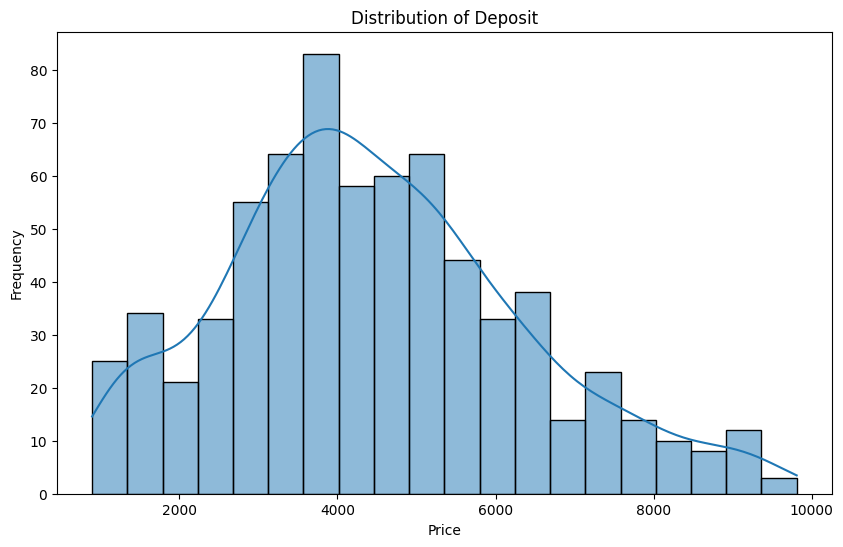

In [22]:
# Plot the distribution of deposit
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_month'], bins=20, kde=True)
plt.title('Distribution of Deposit')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

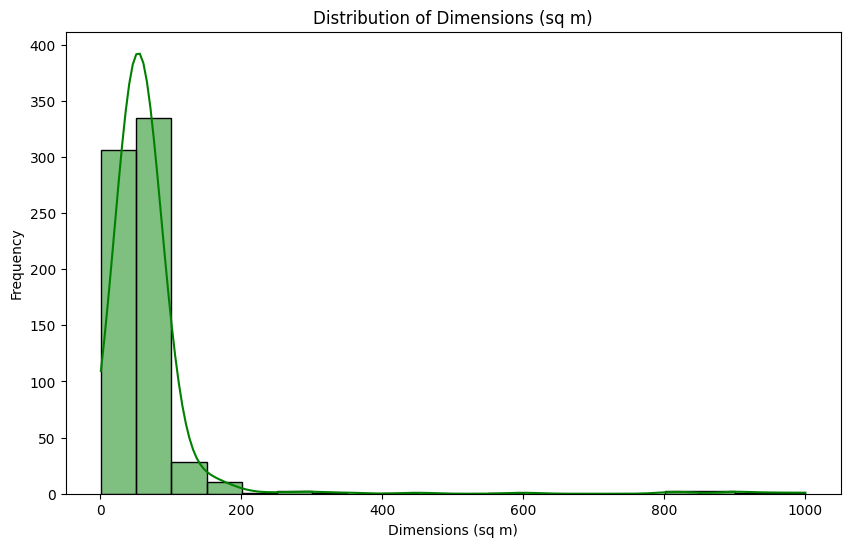

In [23]:
# Plot the distribution of dimensions_sq_m
plt.figure(figsize=(10, 6))
sns.histplot(df['dimensions_sq_m'].dropna(), bins=20, kde=True, color='green')
plt.title('Distribution of Dimensions (sq m)')
plt.xlabel('Dimensions (sq m)')
plt.ylabel('Frequency')
plt.show()

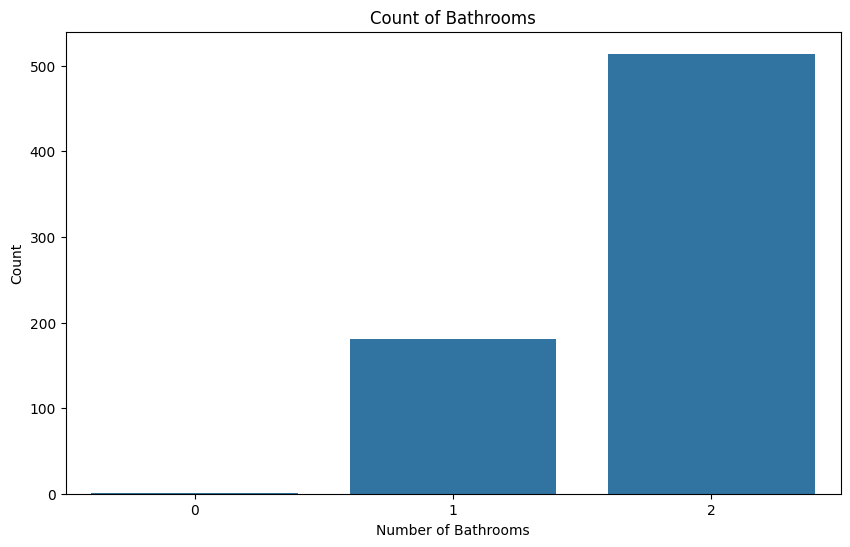

In [24]:
# Plot the count of bathrooms
plt.figure(figsize=(10, 6))
sns.countplot(data=df.dropna(subset=['bathrooms']), x='bathrooms')
plt.title('Count of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
plt.show()

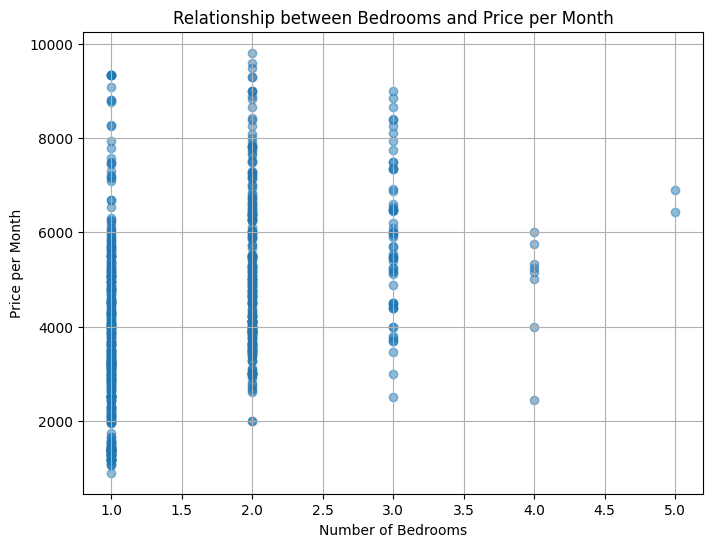

In [25]:
# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['bedrooms'], df['price_per_month'], alpha=0.5)
plt.title('Relationship between Bedrooms and Price per Month')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price per Month')
plt.grid(True)
plt.show()